In [1]:
import urllib.request
import pickle, csv, json, os, re
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode, mean, median
from tqdm import tqdm
import requests

plt.rcParams["figure.figsize"] = (20,10)

# Data

We load in our stored local animes and mangas

In [2]:
import os
anime_dir_path = "data/animes/"

anime_dir = os.listdir(anime_dir_path)
all_animes = []
for file in anime_dir:
    with open(os.path.join(anime_dir_path, file),'r') as f:
        j = json.loads(f.read())
    all_animes.append(j)

In [3]:
all_anime_tv = [x for x in all_animes if x['type'] == 'TV']
print(len(all_anime_tv))
all_anime_tv = [x for x in all_anime_tv if x['score']]
print(len(all_anime_tv))
all_anime_tv = [x for x in all_anime_tv if x['synopsis']]
print(len(all_anime_tv))

8228
4323
4304


In [18]:
anime_graph = nx.read_weighted_edgelist("data/edgeanimelist.txt")

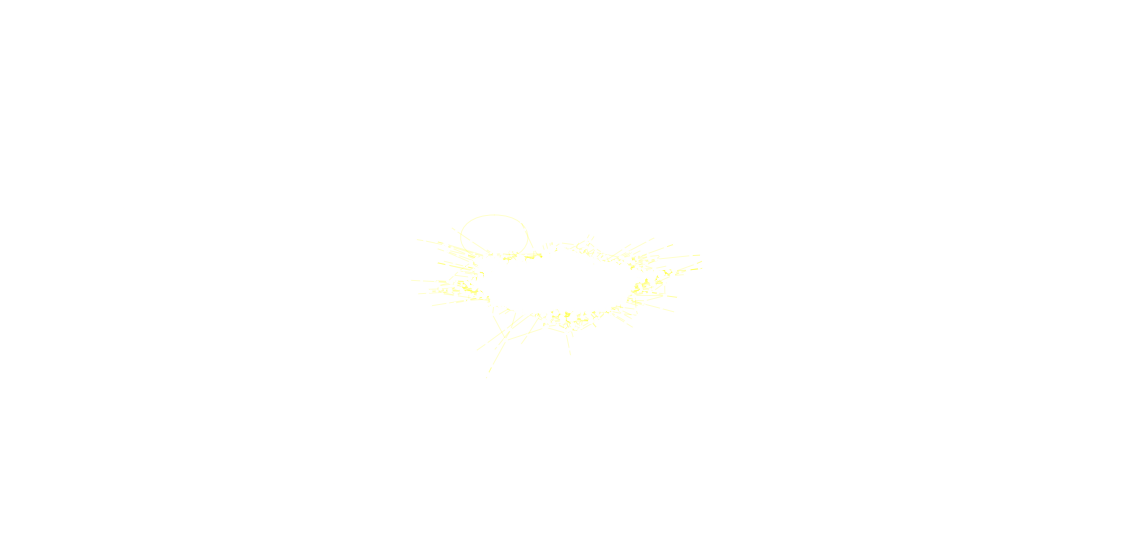

In [24]:
import fa2
d = dict(anime_graph.degree)
def fa_plot(graph,d,node_scale):
    color_map = []

    # for n in graph.nodes:
    #     if 'attr' in graph.nodes[n]:
    #         t = graph.nodes[n]['attr']['team']
    #         if t == 'dc':
    #             color_map.append("#ff0000")
    #         elif t =='marvel':
    #             color_map.append("#A0CBE2")
    #     else:
    #         color_map.append("#000000")
            
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=500)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    nx.draw_networkx_nodes(graph, positions, node_size=[v * node_scale for v in d.values()], alpha=1, node_color='w')
    #Give the nodes their correct color
    nx.draw_networkx_nodes(graph, positions, node_color=color_map, node_size=[v * node_scale for v in d.values()], alpha=0.7)
    plt.axis('off')
    plt.show()
    
fa_plot(anime_graph,d,2)

# Sentiment

First we get the synopsis of each anime tv show, and store it in a seperate text file.

In [ ]:
for anime in all_anime_tv:
    file_name = "{}.txt".format(anime['mal_id'])
    write_file = open("data/synopsis/"+file_name, "w")
    write_file.write(json.dumps(anime['synopsis']))
    write_file.close()

Tokenize the synopsis, and remove stop words.

In [13]:
from bs4 import BeautifulSoup
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
#The root is the directory
corpus_root_dc = r"data/synopsis" 
file_pattern = r".*\.txt"
ptb_dc = PlaintextCorpusReader(corpus_root_dc, file_pattern)
xx = 0
token_dict = {}
for fileid in ptb_dc.fileids():
    raw = ptb_dc.raw(fileids=fileid)
    #raw = BeautifulSoup(html, 'html.parser').get_text()
    try: 
        start = re.search('\"',raw).span()[1]
    except AttributeError:
        print("error")
    tokens = word_tokenize(raw[start:])
    token_dict[fileid.split('.txt')[0]] = [w.lower() for w in tokens if w.isalpha()]

stop_words = stopwords.words('english')

for k,v in token_dict.items(): #remove stop words from token_dict for later sentiment use
    token_dict[k] = [w for w in v if w not in stop_words]

Store the average happiness score of words:

In [16]:
class Word:
    def __init__(self,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank):
        self.word = word
        self.happiness_average = float(happiness_average)

labMIT = {}
with open("labMIT.txt") as f:
    for line in f:
       (word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank) = line.split()
       labMIT[word] = Word(word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank)


We create a function that can calculate the sentiment of a given tokenlist

In [17]:
def get_sentiment(tokenlist):
    sentiment = 0
    num_of_tokens = len(tokenlist)
    if num_of_tokens == 0:
        print('input tokenlist was empty')
        num_of_tokens = 1
    
    for w in tokenlist:
        try: 
            sentiment = sentiment + (labMIT[str(w)].happiness_average)
        except KeyError:
            if num_of_tokens > 1:
                num_of_tokens = num_of_tokens-1
                
    sentiment = sentiment/num_of_tokens
    return sentiment

We can now calculate the sentiment of all the synopsis

In [20]:
fails = 0
sentiments = []
for mal_id in anime_graph.nodes:
    try:
        s = get_sentiment(token_dict[str(mal_id)])
        anime_graph.nodes[mal_id]['Sentiment'] = s
        if s != 0: #We dont consider pages with sentiment 0, as these contain no words in our sentiment library.
            sentiments.append(s)
    except KeyError:
        fails = fails + 1

#print(fails,"nodes could not have their sentiment calculated")

We define a couple of functions for plotting pretty histograms along with their mean, as well as 10th and 90th percentile.

The functions: outlier_aware_sentiment_hist, mad, calculate_bounds is a modified version of the code posted by user Benjamin Doughty in the stackoverflow thread [Making pyplot.hist() first and last bins include outliers](https://stackoverflow.com/questions/15837810/making-pyplot-hist-first-and-last-bins-include-outliers)

In [22]:
def outlier_aware_sentiment_hist(data,mean,tenth,ninetieth,t,sent=False,lower=None, upper=None):
    if not lower or lower < min(data):
        lower = min(data)
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > max(data):
        upper = max(data)
        upper_outliers = False
    else:
        upper_outliers = True

    n, bins, patches = plt.hist(data, range=(lower, upper), bins='auto',edgecolor='black')

    if lower_outliers:
        n_lower_outliers = sum(data < lower)
        patches[0].set_height(patches[0].get_height() + n_lower_outliers)
        patches[0].set_facecolor('c')
        patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower))

    if upper_outliers:
        n_upper_outliers = sum(data > upper)
        patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
        patches[-1].set_facecolor('m')
        patches[-1].set_label('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data)))
    if sent:
        plt.plot([mean,mean],[0,max(n)*1.02],linewidth=5)
        plt.plot([tenth,tenth],[0,max(n)*1.02],linewidth=5)
        plt.plot([ninetieth,ninetieth],[0,max(n)*1.02],linewidth=5)
        plt.legend(['Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower),('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data))),('Distribution Mean: {:.2f}'.format(mean)),('10th percentile: {:.2f}'.format(tenth)),'90th percentile: {:.2f}'.format(ninetieth)])
        plt.xlabel('Sentiment value')
        plt.ylabel('Count')
    else:
        plt.legend()
    plt.title(t)
        
def mad(data):
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    return mad

def calculate_bounds(data, z_thresh=3.5):
    MAD = mad(data)
    median = np.median(data)
    const = z_thresh * MAD / 0.6745
    return (median - const, median + const)

def sentiment_stats_and_hist(sents,t):
    sent_mean = mean(sents)
    tenth = np.percentile(sents,10)
    ninetieth = np.percentile(sents,90)
    print("Sentiment mean:",sent_mean)
    print("tenth percentile:",tenth)
    print("ninetieth percentile:",ninetieth)
    outlier_aware_sentiment_hist(sents,sent_mean,tenth,ninetieth,t,True,*calculate_bounds(sents))


Sentiment mean: 5.705746792427845
tenth percentile: 5.356531103678929
ninetieth percentile: 6.0447653125


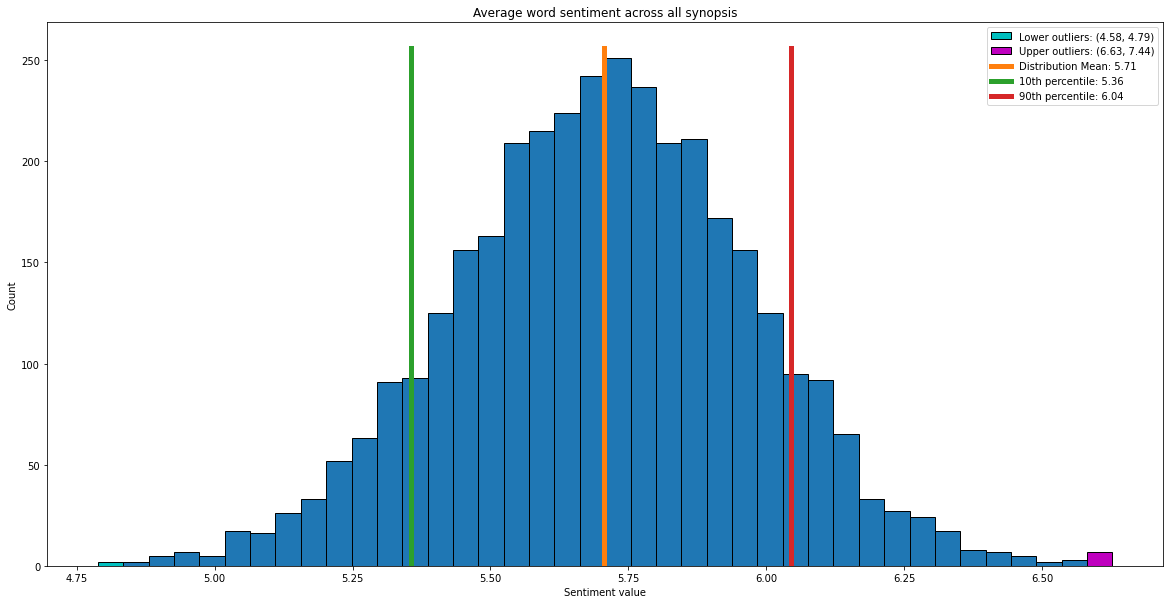

In [23]:
sentiment_stats_and_hist(sentiments,'Average word sentiment across all synopsis')

# Next steps

Split datasettet op i nogle kategorier og sammenlign?<br>F.eks. høj rating vs lav rating? men hvor er cut offet?<br>
Evt. gradierer farven på noderne i plottet alt efter rating? hvis det er muligt, kunne være blæret.<br>
Evt. et møde med sune for at høre hvad der giver mening.